Data description:

features: array of strings, 1x11, a list of water indices to measure

location_ids: array of integer, 37x1, IDs of the water stations

X_te: array of matrices, 1x282, test set input data: water indices for 282 contiguous dates, each element is a 37x11 matrix: 37 spatial locations by 11 features

X_tr: array of matrices, 1x423, training set input data for 423 contiguous dates

Y_te: array of matrices, 37x282, test set output data: water quiality for 37 locations in 282 contiguous dates

Y_tr: array of matrices, 37x423, training set output data for 423 contiguous dates

location_group: array of cells, 1x3, the groups of water stations, each group forms a connected spatial network (i.e., water system)

In [1]:
from scipy.io import loadmat

data = loadmat('water_dataset.mat')

print(data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'X_tr', 'X_te', 'Y_tr', 'Y_te', 'location_group', 'features', 'location_ids'])


In [2]:
features = [str(feat[0]) for feat in data['features'][0]]
location_ids = [int(location[0]) for location in data['location_ids']]
X_te = data['X_te']
X_tr = data['X_tr']
Y_te = data['Y_te']
Y_tr = data['Y_tr']
location_group = [group[0].tolist() for group in data['location_group'][0]]

print("Features: ")
for feat in features:
    print("\t" + feat)
print(location_ids)
print(X_te.shape)
print(X_tr.shape)
print(Y_te.shape)
print(Y_tr.shape)
print(location_group)

Features: 
	Specific conductance, water, unfiltered, microsiemens per centimeter at 25 degrees Celsius (Maximum)
	pH, water, unfiltered, field, standard units (Maximum)
	pH, water, unfiltered, field, standard units (Minimum)
	Specific conductance, water, unfiltered, microsiemens per centimeter at 25 degrees Celsius (Minimum)
	Specific conductance, water, unfiltered, microsiemens per centimeter at 25 degrees Celsius (Mean)
	Dissolved oxygen, water, unfiltered, milligrams per liter (Maximum)
	Dissolved oxygen, water, unfiltered, milligrams per liter (Mean)
	Dissolved oxygen, water, unfiltered, milligrams per liter (Minimum)
	Temperature, water, degrees Celsius (Mean)
	Temperature, water, degrees Celsius (Minimum)
	Temperature, water, degrees Celsius (Maximum)
[2198840, 2198920, 2198950, 2203603, 2203655, 2203700, 2203831, 2203863, 2203873, 2203900, 2203950, 2203960, 2204037, 2207135, 2207160, 2208450, 2208493, 2336120, 2336152, 2336240, 2336300, 2336313, 2336340, 2336360, 2336410, 233652

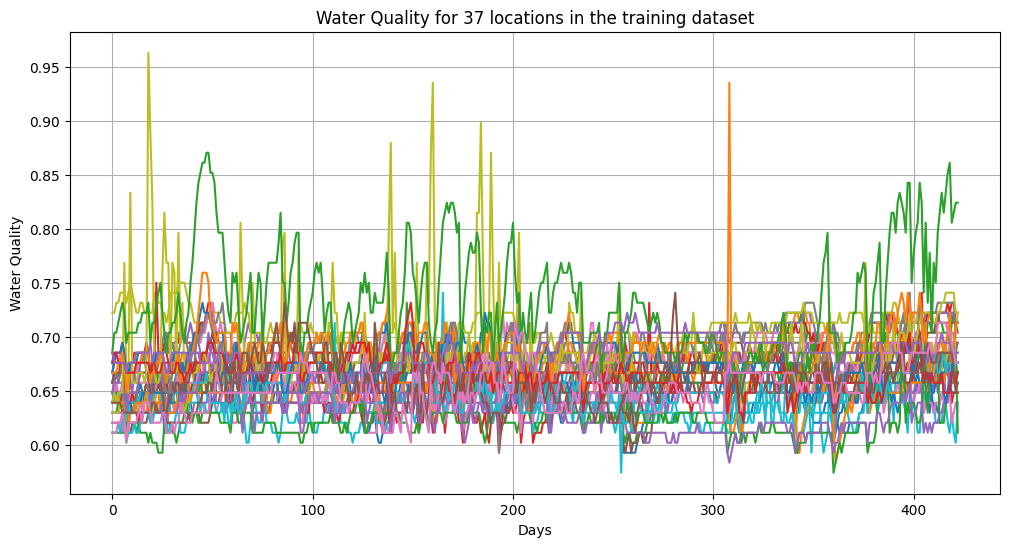

In [3]:
import matplotlib.pyplot as plt

# Get the number of locations and days
num_locations, num_days = Y_tr.shape

# Create the plot
plt.figure(figsize=(12, 6))

# Plot each location's values over the 282 days
for i in range(num_locations):
    plt.plot(range(num_days), Y_tr[i, :], label=f'Location {i+1}')

plt.xlabel('Days')
plt.ylabel('Water Quality')
plt.title('Water Quality for 37 locations in the training dataset')
plt.grid(True)

plt.show()

In [129]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import numpy as np
from sklearn.decomposition import PCA

In [5]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [143]:
class WaterSequenceDataset(Dataset):
    def __init__(self, X, Y, seq_length, n_components):
        self.X = X
        self.Y = Y
        self.seq_length = seq_length
        self.pca = PCA(n_components=n_components)
        self.pca.fit(self.X[0, 0]) # Fit on the first element of first sequence

    def __len__(self):
        return self.X.shape[1] - self.seq_length + 1 # Number of possible sequences

    def __getitem__(self, idx):
        # Extract sequence of inputs and target
        x = self.X[0, idx : idx + self.seq_length]
        x = np.array([np.array(xi, dtype=np.float32) for xi in x])
        x = torch.tensor(x, dtype=torch.float32)

        # Reshape before applying PCA
        original_shape = x.shape
        x = x.reshape(-1, x.shape[-1])

        # Apply PCA for feature extraction by dimension reduction
        x_pca = self.pca.transform(x)
        x_pca = torch.tensor(x_pca.reshape(original_shape[0], original_shape[1], -1), dtype=torch.float32)

        y = self.Y[:, idx + self.seq_length - 1]
        y = torch.tensor(y, dtype=torch.float32)

        return x_pca, y

In [146]:
class ConvLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, num_layers, output_dim):
        super(ConvLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.conv = nn.Conv2d(input_dim, hidden_dim, kernel_size=kernel_size)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, num_layers)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Apply convolution
        x = x.permute(0, 3, 1, 2)
        x = self.conv(x)

        # Reshape for LSTM
        x = x.view(x.size(0), self.hidden_dim, -1)
        x = x.permute(2, 0, 1)

        # Initialize hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(1), self.hidden_dim).to(device)
        c0 = torch.zeros(self.num_layers, x.size(1), self.hidden_dim).to(device)

        # Pass through LSTM
        out, _ = self.lstm(x, (h0, c0))

        # Take the output from the last timestep
        out = out[-1, :, :]

        # Pass through fully connect layer
        out = self.fc(out)
        return out

In [163]:
# Create data loaders
n_components = 3 # Change for PCA

train_dataset = WaterSequenceDataset(X_tr, Y_tr, seq_length=10, n_components=n_components)
test_dataset = WaterSequenceDataset(X_te, Y_te, seq_length=10, n_components=n_components)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [290]:
num_epochs = 7

model = ConvLSTM(input_dim=n_components, hidden_dim=128, kernel_size=3, num_layers=2, output_dim=37).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
for epoch in range(num_epochs):
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        model.train()
        inputs = inputs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        train_loss = criterion(outputs, targets)
        train_loss.backward()
        optimizer.step()

        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                test_loss += loss.item()

        test_loss /= len(test_loader)

        print(f"Epoch [{epoch + 1}/{num_epochs}], Batch [{batch_idx + 1}/{len(train_loader)}], Train Loss: {train_loss.item():.4f}, Test Loss: {test_loss:.4f}")

Epoch [1/7], Batch [1/13], Train Loss: 0.4575, Test Loss: 0.4361
Epoch [1/7], Batch [2/13], Train Loss: 0.4360, Test Loss: 0.4192
Epoch [1/7], Batch [3/13], Train Loss: 0.4038, Test Loss: 0.4008
Epoch [1/7], Batch [4/13], Train Loss: 0.3807, Test Loss: 0.3785
Epoch [1/7], Batch [5/13], Train Loss: 0.3386, Test Loss: 0.3498
Epoch [1/7], Batch [6/13], Train Loss: 0.2856, Test Loss: 0.3104
Epoch [1/7], Batch [7/13], Train Loss: 0.2137, Test Loss: 0.2540
Epoch [1/7], Batch [8/13], Train Loss: 0.1527, Test Loss: 0.1765
Epoch [1/7], Batch [9/13], Train Loss: 0.0776, Test Loss: 0.1056
Epoch [1/7], Batch [10/13], Train Loss: 0.0802, Test Loss: 0.0702
Epoch [1/7], Batch [11/13], Train Loss: 0.0701, Test Loss: 0.0524
Epoch [1/7], Batch [12/13], Train Loss: 0.0616, Test Loss: 0.0358
Epoch [1/7], Batch [13/13], Train Loss: 0.0442, Test Loss: 0.0212
Epoch [2/7], Batch [1/13], Train Loss: 0.0241, Test Loss: 0.0123
Epoch [2/7], Batch [2/13], Train Loss: 0.0114, Test Loss: 0.0101
Epoch [2/7], Batch [3

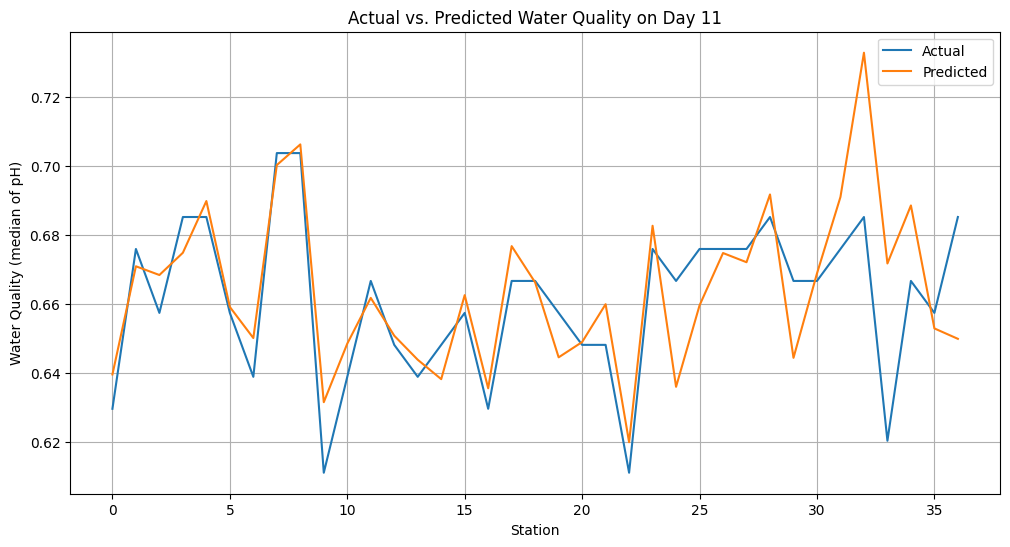

In [311]:
#Evaluation
model.eval()
with torch.no_grad():
    all_predictions = []
    all_targets = []
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)
        all_predictions.append(outputs.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

all_predictions = np.concatenate(all_predictions, axis=0)
all_targets = np.concatenate(all_targets, axis=0)

day_index = 10 # Change this to the desired day index

day_targets = all_targets[day_index, :]
day_predictions = all_predictions[day_index, :]

plt.figure(figsize=(12, 6))
plt.plot(day_targets, label='Actual')
plt.plot(day_predictions, label='Predicted')
plt.xlabel("Station")
plt.ylabel("Water Quality (median of pH)")
plt.title(f"Actual vs. Predicted Water Quality on Day {day_index + 1}")
plt.legend()
plt.grid(True)
plt.show()